##### Copyright 2020 The TensorFlow Authors.

In [1]:
import os
import pathlib
import math

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
audio_length_ms = 100

In [2]:
data_dir = pathlib.Path('./dataset/mono' + str(audio_length_ms) + 'ms')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['kick' 'noise' 'snare' 'kicksnare']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
num_samples_per_label = len(tf.io.gfile.listdir(str(data_dir/commands[0])))
print('Number of examples per label:', num_samples_per_label)
print('Example file tensor:', filenames[0])

Number of total examples: 539
Number of examples per label: 198
Example file tensor: tf.Tensor(b'dataset/mono100ms/snare/snare43.wav', shape=(), dtype=string)


2022-05-30 22:36:36.746136: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
count_train_files = math.floor(num_samples * .8)
train_files = filenames[:count_train_files]

count_val_files = math.floor(num_samples * .1) + count_train_files+1
val_files = filenames[count_train_files+1: count_val_files]

test_files = filenames[count_val_files+1:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 431
Validation set size 53
Test set size 53


## Leia os arquivos de áudio e seus rótulos

Nesta seção você irá pré-processar o conjunto de dados, criando tensores decodificados para as formas de onda e os rótulos correspondentes. Observe que:

- Cada arquivo WAV contém dados de séries temporais com um número definido de amostras por segundo.
- Cada amostra representa a <a href="https://en.wikipedia.org/wiki/Amplitude" class="external">amplitude</a> do sinal de áudio naquele momento específico.
- Em um sistema <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16 bits</a>, como os arquivos WAV no conjunto de dados mini Speech Commands, a amplitude os valores variam de -32.768 a 32.767.
- A <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">taxa de amostragem</a> para este conjunto de dados é de 16 kHz.

A forma do tensor retornado por `tf.audio.decode_wav` é `[amostras, canais]`, onde `canais` é `1` para mono ou `2` para estéreo. O conjunto de dados mini Speech Commands contém apenas gravações mono.

In [6]:
test_file = tf.io.read_file(str(data_dir) + '/kick/kick2.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([1600, 1])

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [7]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [8]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Let's plot a few audio waveforms:

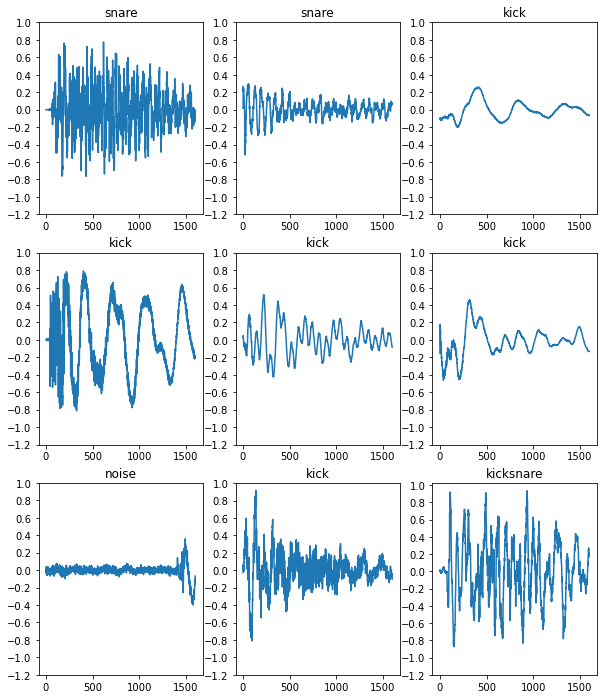

In [11]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Converter formas de onda em espectrogramas

As formas de onda no conjunto de dados são representadas no domínio do tempo. Em seguida, você transformará as formas de onda dos sinais do domínio do tempo em sinais do domínio da frequência do tempo calculando o <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external ">transformada de Fourier de curta duração (STFT)</a> para converter as formas de onda em <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">espectrogramas</a> , que mostram mudanças de frequência ao longo do tempo e podem ser representadas como imagens 2D. Você alimentará as imagens do espectrograma em sua rede neural para treinar o modelo.

Uma transformada de Fourier (`tf.signal.fft`) converte um sinal para suas frequências componentes, mas perde todas as informações de tempo. Em comparação, STFT (`tf.signal.stft`) divide o sinal em janelas de tempo e executa uma transformada de Fourier em cada janela, preservando algumas informações de tempo e retornando um tensor 2D no qual você pode executar convoluções padrão.

Crie uma função utilitária para converter formas de onda em espectrogramas:

- As formas de onda precisam ter o mesmo comprimento, para que, ao convertê-las em espectrogramas, os resultados tenham dimensões semelhantes. Isso pode ser feito simplesmente zerando os clipes de áudio com menos de um segundo (usando `tf.zeros`).
- Ao chamar `tf.signal.stft`, escolha os parâmetros `frame_length` e `frame_step` de forma que a "imagem" do espectrograma gerado seja quase quadrada. Para obter mais informações sobre a escolha dos parâmetros STFT, consulte <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">este vídeo do Coursera< /a> no processamento de sinal de áudio e STFT.
- O STFT produz uma matriz de números complexos representando magnitude e fase. No entanto, neste tutorial você usará apenas a magnitude, que você pode derivar aplicando `tf.abs` na saída de `tf.signal.stft`.

In [133]:
sample_len = int (audio_length_ms / 50) * 800

def get_spectrogram(waveform):
  # Zero-padding para uma forma de onda de áudio com menos de 16.000 amostras.
  input_len = sample_len
  waveform = waveform[:input_len]
  zero_padding = tf.zeros([input_len] - tf.shape(waveform), dtype=tf.float32)
  # Transmita o dtype dos tensores de forma de onda para float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatene a forma de onda com `zero_padding`, o que garante que todos os 
  # clipes de áudio tenham a mesma duração.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Converta a forma de onda em um espectrograma por meio de um STFT.
  spectrogram = tf.signal.stft(equal_length, frame_length=50, frame_step=16)
  # Obtenha a magnitude do STFT.
  spectrogram = tf.abs(spectrogram)
  # Adicione uma dimensão `channels`, para que o espectrograma possa ser usado como 
  # dados de entrada semelhantes a imagens com camadas de convolução 
  # (que esperam forma (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Em seguida, comece a explorar os dados. Imprima as formas da forma de onda tensorizada de um exemplo e o espectrograma correspondente e reproduza o áudio original:

In [134]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: snare
Waveform shape: (1600,)
Spectrogram shape: (97, 33, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [135]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

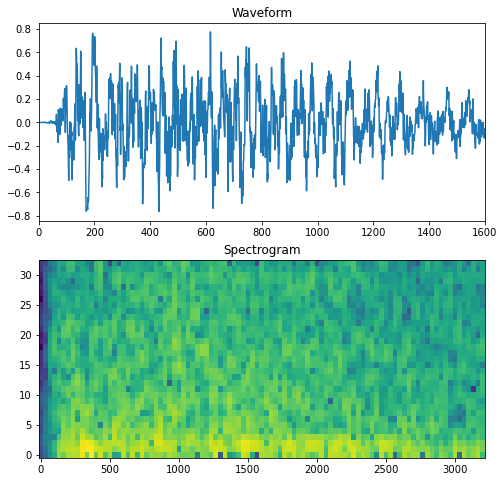

In [136]:
fig, axes = plt.subplots(2, figsize=(8, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, sample_len])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()
display.display(display.Audio(waveform, rate=16000))

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [137]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [138]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

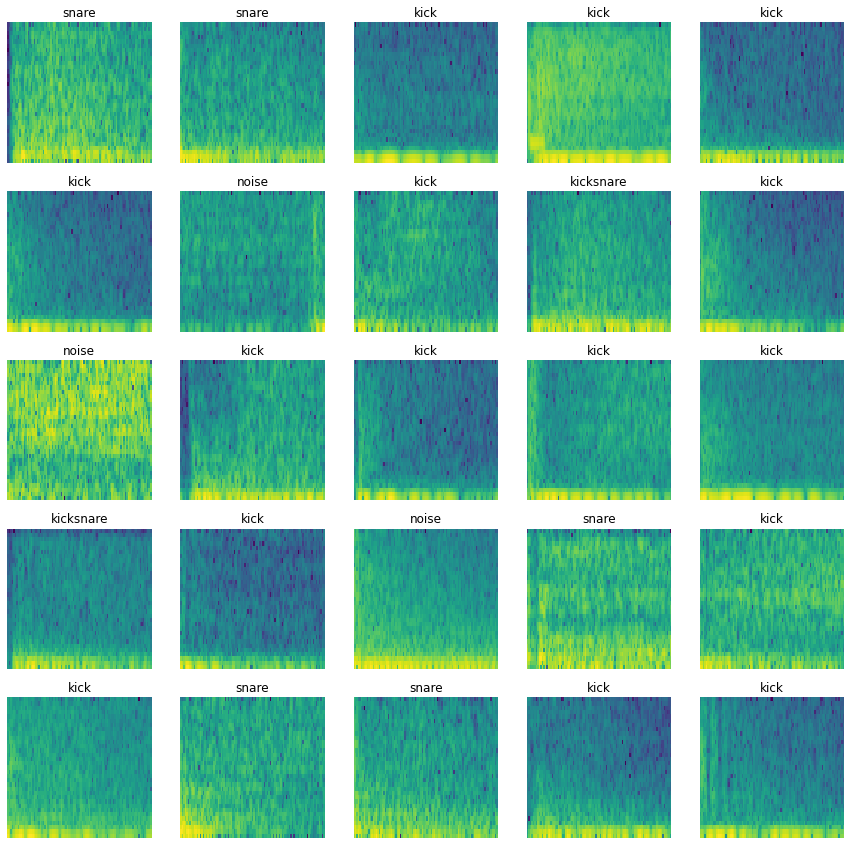

In [139]:
rows = 5
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Construir e treinar o modelo

Repita o pré-processamento do conjunto de treinamento nos conjuntos de validação e teste:

In [140]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [141]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training:

In [142]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [143]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Para o modelo, você usará uma rede neural convolucional simples (CNN), pois transformou os arquivos de áudio em imagens de espectrograma.

Seu modelo `tf.keras.Sequential` usará as seguintes camadas de pré-processamento Keras:

- `tf.keras.layers.Resizing`: para reduzir a amostra da entrada para permitir que o modelo treine mais rápido.
- `tf.keras.layers.Normalization`: para normalizar cada pixel da imagem com base em sua média e desvio padrão.

Para a camada `Normalization`, seu método `adapt` precisaria primeiro ser chamado nos dados de treinamento para calcular estatísticas agregadas (ou seja, a média e o desvio padrão).

In [144]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instancie a camada `tf.keras.layers.Normalization`.
norm_layer = layers.Normalization()
# Ajuste o estado da camada aos espectrogramas com `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (97, 33, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_6 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [145]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 30 epochs for demonstration purposes:

In [146]:
EPOCHS = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)
model.save(filepath='./models/model'+str(audio_length_ms)+'ms')

Epoch 1/30
7/7 [==============================] - 1s 135ms/step - loss: 1.2635 - accuracy: 0.4803 - val_loss: 1.0366 - val_accuracy: 0.6981
Epoch 2/30
7/7 [==============================] - 1s 99ms/step - loss: 0.9726 - accuracy: 0.7146 - val_loss: 0.8081 - val_accuracy: 0.7358
Epoch 3/30
7/7 [==============================] - 1s 102ms/step - loss: 0.7582 - accuracy: 0.7541 - val_loss: 0.6361 - val_accuracy: 0.7547
Epoch 4/30
7/7 [==============================] - 1s 93ms/step - loss: 0.6471 - accuracy: 0.7819 - val_loss: 0.5200 - val_accuracy: 0.8491
Epoch 5/30
7/7 [==============================] - 1s 101ms/step - loss: 0.5364 - accuracy: 0.8144 - val_loss: 0.4430 - val_accuracy: 0.8679
Epoch 6/30
7/7 [==============================] - 1s 107ms/step - loss: 0.4851 - accuracy: 0.8213 - val_loss: 0.3832 - val_accuracy: 0.8491
Epoch 7/30
7/7 [==============================] - 1s 100ms/step - loss: 0.4039 - accuracy: 0.8654 - val_loss: 0.3635 - val_accuracy: 0.8868
Epoch 8/30
7/7 [======

Vamos plotar as curvas de perda de treinamento e validação para verificar como seu modelo melhorou durante o treinamento:

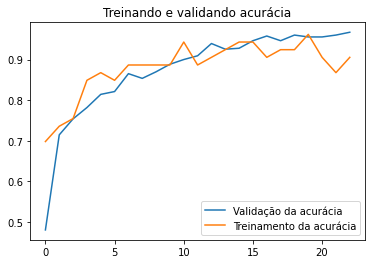

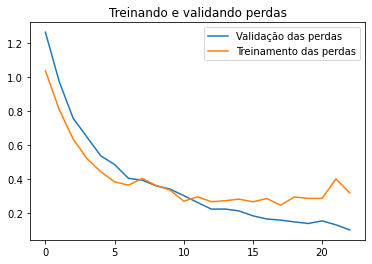

In [147]:
metrics = history.history

plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['Validação da acurácia', 'Treinamento da acurácia'])
plt.title('Treinando e validando acurácia')
plt.figure()

plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['Validação das perdas', 'Treinamento das perdas'])
plt.title('Treinando e validando perdas')
plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [148]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [149]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


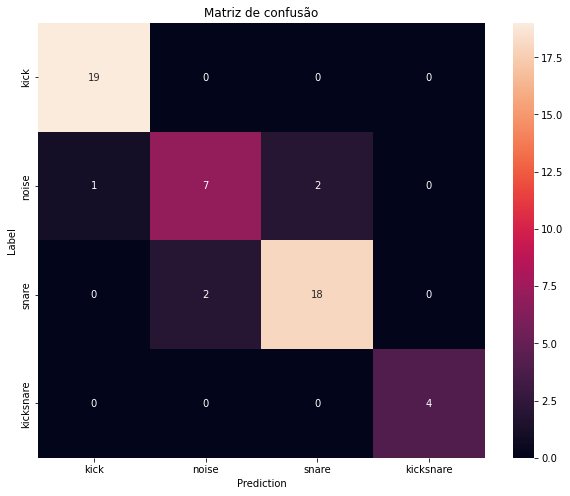

In [90]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Matriz de confusão')
plt.show()

## Run inference on an audio file



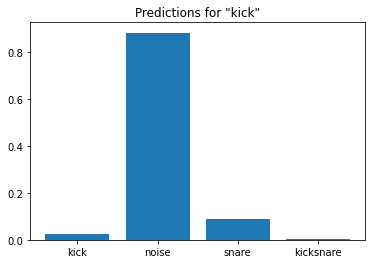

In [91]:
data_test_dir = pathlib.Path('./dataset/test')
# sample_file = data_test_dir/'kick.wav'
# sample_file = data_test_dir/'snare.wav'
sample_file = data_test_dir/'noise.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()